In [1]:
import pickle
import torch
import sys, os
import cv2 as cv
import h5py
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import transformations as tf
import numpy as np
from itertools import repeat

np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

In [2]:
act_path = "/home/zfei/code/act-plus-plus/"
sys.path.append(act_path)
from policy import EPACTPolicy, ACTPolicy, DINOPolicy
from brl_constants import TASK_CONFIGS
from utils import EpisodicDataset
from utils import find_all_hdf5, flatten_list, get_norm_stats
from utils import load_data # data functions

ROBOMIMIC WARNING(
    No private macro file found!
    It is recommended to use a private macro file
    To setup, run: python /home/zfei/code/robomimic/robomimic/scripts/setup_macros.py
)


In [3]:
ckpt_path = "/mnt/data1/act/train_act_scara_3cam/3cam_epact_v4_1_lep10/"
config_path = ckpt_path + "config.pkl"

with open(config_path, "rb") as f:
    policy_config = pickle.load(f)['policy_config']
    policy_config["ep_weight"] = 1.0

act_policy_config = copy.copy(policy_config)
dino_policy_config = copy.copy(policy_config)

act_policy_config['hidden_dim'] = 384


In [4]:
dino_policy_config['hidden_dim'] = 384
dino_policy_config['backbone'] = 'vits'
dino_policy_config


{'lr': 1e-05,
 'num_queries': 100,
 'kl_weight': 10,
 'ep_weight': 1.0,
 'hidden_dim': 384,
 'dim_feedforward': 3200,
 'lr_backbone': 1e-05,
 'backbone': 'vits',
 'enc_layers': 4,
 'dec_layers': 7,
 'nheads': 8,
 'camera_names': ['wrist', 'wrist_down', 'top'],
 'vq': False,
 'vq_class': None,
 'vq_dim': None,
 'action_dim': 5,
 'state_dim': 4,
 'no_encoder': False}

In [5]:
# policy_act = ACTPolicy(act_policy_config)
# policy_class = "DINOACT"


In [6]:
policy_dino = DINOPolicy(dino_policy_config)
policy_class = "DINOACT"



DINO Args:  Namespace(lr=1e-05, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=300, lr_drop=200, clip_max_norm=0.1, backbone='vits', dilation=False, position_embedding='sine', camera_names=['wrist', 'wrist_down', 'top'], enc_layers=4, dec_layers=7, dim_feedforward=3200, hidden_dim=384, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, eval=False, onscreen_render=False, ckpt_dir='/mnt/data1/act/act_demo_z1_push_red/ckpt', policy_class='DINOACT', task_name='act_demo_z1_push_red', seed=0, num_steps=2000, kl_weight=10, chunk_size=None, temporal_agg=False, use_vq=False, vq=False, vq_class=None, vq_dim=None, load_pretrain=False, action_dim=5, eval_every=500, validate_every=500, save_every=500, resume_ckpt_path=None, no_encoder=False, skip_mirrored_data=False, actuator_network_dir=None, history_len=None, future_len=None, prediction_len=None, ep_weight=1.0, state_dim=4)
[DETRVAE]: state_dim: 4, hidden_dim: 384, action_dim: 5
Use end_pose_to_action:  False
Use V

In [7]:
camera_names = policy_config["camera_names"]
print(camera_names)

['wrist', 'wrist_down', 'top']


In [8]:

def forward_pass(data, policy):
    image_data, qpos_data, action_data, is_pad = data
    image_data, qpos_data, action_data, is_pad = image_data.cuda(), qpos_data.cuda(), action_data.cuda(), is_pad.cuda()
    return policy(qpos_data, image_data, action_data, is_pad) # TODO remove None

def repeater(data_loader):
    epoch = 0
    for loader in repeat(data_loader):
        for data in loader:
            yield data
        print(f'Epoch {epoch} done')
        epoch += 1

In [9]:
dataset_path_list = find_all_hdf5("/mnt/data1/act/train_act_scara_3cam/data1/", skip_mirrored_data=False)
norm_stats, all_episode_len = get_norm_stats(dataset_path_list)

camera_names = ['wrist', 'wrist_down', 'top']
train_episode_ids = [0, 1]
train_episode_len = [all_episode_len[i] for i in train_episode_ids]

val_episode_ids = [0, 1]
val_episode_len = [all_episode_len[i] for i in val_episode_ids]

chunk_size = 64


Found 51 hdf5 files


In [10]:
dataset_dir = "/mnt/data1/act/train_act_scara_3cam/data1/"

TASK_CONFIGS = {
        'epact':{
        'dataset_dir': dataset_dir + '/train_act_scara_3cam',
        'num_episodes': 100,
        'episode_len': 300,
        'camera_names': ['wrist', 'wrist_down', 'top']
    }
}

In [11]:
task_config = TASK_CONFIGS['epact']
name_filter = task_config.get('name_filter', lambda n: True)
batch_size_train = 8
batch_size_val = 8


In [15]:
chunk_size = 100
skip_mirrored_data = False
load_pretrain = False
train_ratio = 0.99
resize = None
resize = (518, 518)
train_dataloader,val_dataloader, stats, _ = load_data(dataset_dir, 
                                                       name_filter, 
                                                       camera_names, 
                                                       batch_size_train, 
                                                       batch_size_val, 
                                                       chunk_size,
                                                       skip_mirrored_data,
                                                       load_pretrain,
                                                       policy_class,
                                                       stats_dir_l=None,
                                                       sample_weights=None,
                                                       train_ratio=train_ratio,
                                                       resize=resize)
train_dataloader = repeater(train_dataloader)


Found 51 hdf5 files


Data from: ['/mnt/data1/act/train_act_scara_3cam/data1/']
- Train on [50] episodes
- Test on [1] episodes


Found 51 hdf5 files
Norm stats from: ['/mnt/data1/act/train_act_scara_3cam/data1/']
train_episode_len: [136, 129, 136, 103, 132, 177, 165, 128, 135, 124, 135, 98, 135, 127, 128, 121, 106, 116, 168, 154, 104, 140, 137, 108, 175, 107, 118, 120, 117, 114, 151, 161, 118, 125, 116, 121, 101, 124, 117, 110, 118, 153, 154, 144, 90, 104, 168, 111, 110, 123], val_episode_len: [139], train_episode_ids: [14  9 17 30 15 44 49  4 31 23 29  7  8  1 16  2 22 42 19 40  3 50  0  5
 25  6 11 36 35 20 32 37 13 18 39 46 27 28 48 26 33 41 10 45 21 47 34 12
 24 43], val_episode_ids: [38]
val data:  /mnt/data1/act/train_act_scara_3cam/data1/episode_4.hdf5
augment_images:  False
Initializing transformations
augment_images:  False
Initializing transformations
Augment images: False, train_num_workers: 8, val_num_workers: 8


In [17]:
data = next(train_dataloader)
image_data, qpos_data, action_data, is_pad = data

# forward_pass(data, policy_act)
forward_pass(data, policy_dino)



[DEBUG]image torch.Size([8, 3, 3, 518, 518])
[DEBUG]image2 torch.Size([8, 3, 3, 518, 518])
image torch.Size([8, 3, 3, 518, 518])
qpos torch.Size([8, 4])
actions torch.Size([8, 100, 5])
is_pad torch.Size([8, 100])
[DETRVAE]: cam_id: 0, image: torch.Size([8, 3, 518, 518])
DinoBackbone x:  torch.Size([8, 384, 1369])
DinoBackbone x:  torch.Size([8, 384, 375])
DinoBackbone x:  torch.Size([8, 384, 15, 25])
DinoJoiner x:  torch.Size([8, 384, 15, 25])
[DETRVAE]: cam_id: 0, cam_features: torch.Size([8, 384, 15, 25]), pos: torch.Size([1, 384, 15, 25])
[DETRVAE]: cam_id: 1, image: torch.Size([8, 3, 518, 518])
DinoBackbone x:  torch.Size([8, 384, 1369])
DinoBackbone x:  torch.Size([8, 384, 375])
DinoBackbone x:  torch.Size([8, 384, 15, 25])
DinoJoiner x:  torch.Size([8, 384, 15, 25])
[DETRVAE]: cam_id: 1, cam_features: torch.Size([8, 384, 15, 25]), pos: torch.Size([1, 384, 15, 25])
[DETRVAE]: cam_id: 2, image: torch.Size([8, 3, 518, 518])
DinoBackbone x:  torch.Size([8, 384, 1369])
DinoBackbone x:

{'l1': tensor(0.4779, device='cuda:0', grad_fn=<MeanBackward0>),
 'kl': tensor(8.3777, device='cuda:0', grad_fn=<SelectBackward0>),
 'loss': tensor(84.2548, device='cuda:0', grad_fn=<AddBackward0>)}

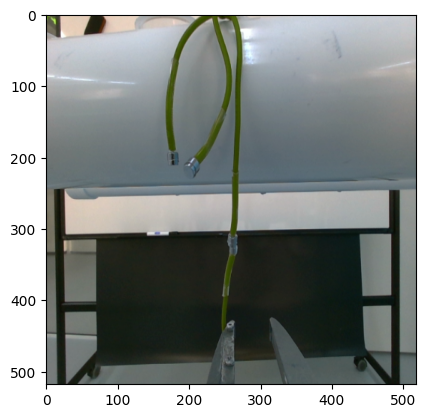

In [23]:
image_data[0][0].shape
img = image_data[0][0].cpu().numpy().transpose(1,2,0)
img.shape
plt.imshow(img)

In [14]:
data = next(train_dataloader)
image_data, qpos_data, action_data, is_pad = data
image_data, qpos_data, action_data, is_pad = image_data.cuda(), qpos_data.cuda(), action_data.cuda(), is_pad.cuda()
print(image_data.shape)


# cam_num = image_data.shape[1]
# channel = image_data.shape[2]
# reshape_size = [518, 518]
# # scale [batch, number, channel, w, h] image into 518 * 518
# image_data = image_data.view(-1, image_data.shape[2], image_data.shape[3], image_data.shape[4])
# image_data = torch.nn.functional.interpolate(image_data, size=(reshape_size[0], reshape_size[1]), mode='bilinear', align_corners=False)
# image_data = image_data.view(-1, cam_num, channel, image_data.shape[2], image_data.shape[3])
# print(image_data.shape)



torch.Size([8, 3, 3, 480, 640])


In [15]:
# data = next(train_dataloader)

# image_data, qpos_data, action_data, is_pad = data
# image_data, qpos_data, action_data, is_pad = image_data.cuda(), qpos_data.cuda(), action_data.cuda(), is_pad.cuda()
# cam_num = image_data.shape[1]
# channel = image_data.shape[2]
# reshape_size = [518, 518]
# # scale [batch, number, channel, w, h] image into 518 * 518
# image_data = image_data.view(-1, image_data.shape[2], image_data.shape[3], image_data.shape[4])
# image_data = torch.nn.functional.interpolate(image_data, size=(reshape_size[0], reshape_size[1]), mode='bilinear', align_corners=False)
# image_data = image_data.view(-1, cam_num, channel, image_data.shape[2], image_data.shape[3])
# print(image_data.shape)
# policy_dino(qpos_data, image_data, action_data, is_pad) # TODO remove None

torch.Size([8, 3, 3, 518, 518])
[DEBUG]image torch.Size([8, 3, 3, 518, 518])
[DEBUG]image2 torch.Size([8, 3, 3, 518, 518])
image torch.Size([8, 3, 3, 518, 518])
qpos torch.Size([8, 4])
actions torch.Size([8, 100, 5])
is_pad torch.Size([8, 100])


[DETRVAE]: cam_id: 0, image: torch.Size([8, 3, 518, 518])
DinoBackbone x:  torch.Size([8, 384, 1369])
DinoBackbone x:  torch.Size([8, 384, 375])
DinoBackbone x:  torch.Size([8, 384, 15, 25])
DinoJoiner x:  torch.Size([8, 384, 15, 25])
[DETRVAE]: cam_id: 0, cam_features: torch.Size([8, 384, 15, 25]), pos: torch.Size([1, 384, 15, 25])
[DETRVAE]: cam_id: 1, image: torch.Size([8, 3, 518, 518])
DinoBackbone x:  torch.Size([8, 384, 1369])
DinoBackbone x:  torch.Size([8, 384, 375])
DinoBackbone x:  torch.Size([8, 384, 15, 25])
DinoJoiner x:  torch.Size([8, 384, 15, 25])
[DETRVAE]: cam_id: 1, cam_features: torch.Size([8, 384, 15, 25]), pos: torch.Size([1, 384, 15, 25])
[DETRVAE]: cam_id: 2, image: torch.Size([8, 3, 518, 518])
DinoBackbone x:  torch.Size([8, 384, 1369])
DinoBackbone x:  torch.Size([8, 384, 375])
DinoBackbone x:  torch.Size([8, 384, 15, 25])
DinoJoiner x:  torch.Size([8, 384, 15, 25])
[DETRVAE]: cam_id: 2, cam_features: torch.Size([8, 384, 15, 25]), pos: torch.Size([1, 384, 15, 

{'l1': tensor(0.5278, device='cuda:0', grad_fn=<MeanBackward0>),
 'kl': tensor(7.4223, device='cuda:0', grad_fn=<SelectBackward0>),
 'loss': tensor(74.7509, device='cuda:0', grad_fn=<AddBackward0>)}

In [1]:
forward_pass(data, policy_act)

NameError: name 'forward_pass' is not defined

In [18]:
forward_pass(data, policy_dino)

[DEBUG]image torch.Size([8, 3, 3, 480, 640])
[DEBUG]image2 torch.Size([8, 3, 3, 480, 640])
image torch.Size([8, 3, 3, 480, 640])
qpos torch.Size([8, 4])
actions torch.Size([8, 100, 5])
is_pad torch.Size([8, 100])


AssertionError: Input image height 480 is not a multiple of patch height 14

In [15]:
action_data = None
policy_act(image_data, qpos_data, action_data, is_pad)

ValueError: Expected tensor to be a tensor image of size (..., C, H, W). Got tensor.size() = torch.Size([8, 4])

In [25]:
policy_act

ACTPolicy(
  (model): DETRVAE(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-3): 4 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
            )
            (linear1): Linear(in_features=384, out_features=3200, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=3200, out_features=384, bias=True)
            (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (decoder): TransformerDecoder(
        (layers): ModuleList(
          (0-6): 7 x TransformerDecoderLayer(
            (self_attn): MultiheadAttention(
        

In [26]:
policy_dino

DINOPolicy(
  (model): DETRVAE(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-3): 4 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
            )
            (linear1): Linear(in_features=384, out_features=3200, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=3200, out_features=384, bias=True)
            (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (decoder): TransformerDecoder(
        (layers): ModuleList(
          (0-6): 7 x TransformerDecoderLayer(
            (self_attn): MultiheadAttention(
       

In [21]:
policy.model.num_queries

100

In [22]:
policy(qpos_data, image_data, action_data, is_pad)

image torch.Size([8, 3, 3, 480, 640])
qpos torch.Size([8, 4])
actions torch.Size([8, 100, 5])
is_pad torch.Size([8, 100])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [13]:
h5data_file = "/mnt/data1/act/train_act_scara_3cam/data1/episode_30.hdf5"

with torch.inference_mode():
    with h5py.File(h5data_file, "r") as root:
        index = 0
        qpos_np = root["/observations/qpos"][index]
        img_wrist_up_np = root["/observations/images/wrist"][index]
        img_wrist_down_np = root["/observations/images/wrist_down"][index]
        img_top_np = root["/observations/images/top"][index]

        qpos_all =  root["/observations/qpos"][()]

        curr_images = [img_wrist_up_np, img_wrist_down_np, img_top_np]

        action_obs_np = root["action"][()]
        qpos = pre_process_qpos(qpos_np)
        curr_images_torch = pre_process_multi_img(curr_images)
        # print("qpos: ",qpos.shape)
        all_actions, all_end_poses = policy(qpos, curr_images_torch)
        all_actions = all_actions.squeeze(0).cpu().numpy()

        print("all_actions: ", all_actions.shape)
        print("action_obs_np: ", action_obs_np.shape)

        # actual_action = post_process_action(raw_action)
        # print("actual action %i"%index, actual_action)


action_obs_np = action_obs_np[index:]
qpos_all = np.asarray(qpos_all)
qpos_all = qpos_all[index:]


all_actions:  (100, 5)
action_obs_np:  (127, 5)
